<a href="https://colab.research.google.com/github/aastikg20/Two-Wheeled-Self-Balancing-Bot/blob/aastikg20/Cell2location.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

In [3]:
!pip install scanpy
import scanpy as sc

In [4]:
!git clone https://github.com/googlecolab/colabtools.git
!cd colabtools && git checkout incoming

fatal: destination path 'colabtools' already exists and is not an empty directory.
Already on 'incoming'
Your branch is up to date with 'origin/incoming'.


In [5]:
import sys

IN_COLAB = "google.colab" in sys.modules

#if IN_COLAB and branch == "stable":
!pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import os
import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


Global seed set to 0


In [6]:
import os

In [7]:
results_folder = './results/mousebrain_analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [8]:
sc_data_folder = './data/'
results_folder = './results/mouse_brain_snrna/'

if os.path.exists(sc_data_folder) is not True:
    os.mkdir(sc_data_folder)
os.system(f'cd {sc_data_folder} && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/all_cells_20200625.h5ad')
os.system(f'cd {sc_data_folder} && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/snRNA_annotation_astro_subtypes_refined59_20200823.csv')


if os.path.exists(results_folder) is not True:
    os.mkdir('./results')
    os.mkdir(results_folder)


## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "all_cells_20200625.h5ad")

## Cell type annotations
labels = pd.read_csv(sc_data_folder + 'snRNA_annotation_astro_subtypes_refined59_20200823.csv', index_col=0)

labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isna(), :]

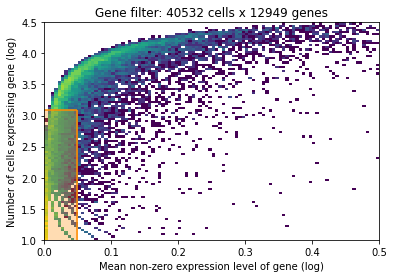

In [9]:
# before we estimate the reference cell type signature we recommend to perform very permissive genes selection
# in this 2D histogram orange rectangle lays over excluded genes.
# In this case, the downloaded dataset was already filtered using this method,
# hence no density under the orange rectangle

adata_ref = adata_snrna_raw.copy()
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
#adata_snrna_raw, adata_ref

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [10]:
adata_ref

AnnData object with n_obs × n_vars = 40532 × 12949
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode', 'annotation_1'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells', 'nonz_mean'

In [11]:
# prepare anndata for the regression model
from cell2location.models import RegressionModel
RegressionModel.setup_anndata(adata=adata_ref, 
                        # 10X reaction / sample / batch
                        batch_key='sample',  # 'Sample'
                        # cell type, covariate used for constructing signatures
                        labels_key='annotation_1', # Subset
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        #categorical_covariate_keys=['Method']
                       )
model=RegressionModel(adata_ref)
model.view_anndata_setup(adata_ref)

Anndata setup with scvi-tools version 0.16.2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'annotation_1',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 40532 │
│          n_vars          │ 12949 │
│         n_batch          │   6   │
│         n_labels         │  59   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ 5705STDY8058280 │          0          │
│                     │ 5705STDY8058281 │          1          │
│                     │ 5705STDY8058282 │          2          │
│                     │ 5705STDY8058283 │          3          │
│                     │ 5705STDY8058284 │          4          │
│                     │ 5705STDY8058285 │          5          │
└─────────────────────┴─────────────────┴─────────────────────┘

                       labels State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['annotation_1'] │   Astro_AMY    │          0          │
│                           │ Astro_AMY_CTX  │          1          │
│                           │   Astro_CTX    │          2          │
│                           │   Astro_HPC    │          3          │
│                           │   Astro_HYPO   │          4          │
│                           │   Astro_STR    │          5          │
│                           │ Astro_THAL_hab │          6          │
│                           │ Astro_THAL_lat │          7          │
│                           │ Astro_THAL_med │          8          │
│                           │    Astro_WM    │          9          │
│                           │      Endo      │         10          │
│                           │   Ext_Amy_1    │         11          │
│                           │   Ext_Amy_2    │         12          │
│                           │  Ext_ClauPyr   │         13          │
│                           │  Ext_Hpc_CA1   │         14          │
│                           │  Ext_Hpc_CA2   │         15          │
│                           │  Ext_Hpc_CA3   │         16          │
│                           │  Ext_Hpc_DG1   │         17          │
│                           │  Ext_Hpc_DG2   │         18          │
│                           │    Ext_L23     │         19          │
│                           │    Ext_L25     │         20          │
│                           │    Ext_L56     │         21          │
│                           │    Ext_L5_1    │         22          │
│                           │    Ext_L5_2    │         23          │
│                           │    Ext_L5_3    │         24          │
│                           │     Ext_L6     │         25          │
│                           │    Ext_L6B     │         26          │
│                           │    Ext_Med     │         27          │
│                           │    Ext_Pir     │         28          │
│                           │   Ext_Thal_1   │         29          │
│                           │   Ext_Thal_2   │         30          │
│                           │   Ext_Unk_1    │         31          │
│                           │   Ext_Unk_2    │         32          │
│                           │   Ext_Unk_3    │         33          │
│                           │     Inh_1      │         34          │
│                           │     Inh_2      │         35          │
│                           │     Inh_3      │         36          │
│                           │     Inh_4      │         37          │
│                           │     Inh_5      │         38          │
│                           │     Inh_6      │         39          │
│                           │   Inh_Lamp5    │         40          │
│                           │  Inh_Meis2_1   │         41          │
│                           │  Inh_Meis2_2   │         42          │
│                           │  Inh_Meis2_3   │         43          │
│                           │  Inh_Meis2_4   │         44          │
│                           │   Inh_Pvalb    │         45          │
│                           │    Inh_Sst     │         46          │
│                           │    Inh_Vip     │         47          │
│                           │     LowQ_1     │         48          │
│                           │     LowQ_2     │         49          │
│                           │     Micro      │         50          │
│                           │      Nb_1      │         51          │
│                           │      Nb_2      │         52          │
│                           │     OPC_1      │         53          

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 1/1: 100%|██████████| 1/1 [00:08<00:00,  8.90s/it, v_num=1, elbo_train=2.6e+8]


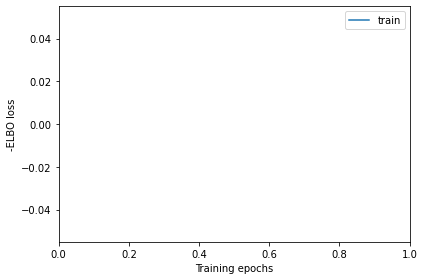

In [12]:
# create and train the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref) 

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=1, batch_size=2500, train_size=1, lr=0.002, use_gpu=True) # used 20 for testing. correct = 250, use_gpu = True

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [13]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:36<00:00, 27.45it/s]


'./results/mousebrain_analysis//reference_signatures/sc.h5ad'

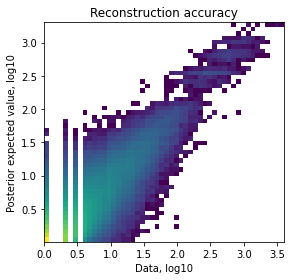

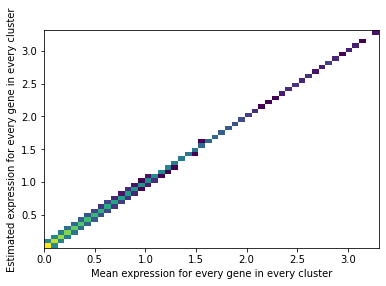

In [14]:
mod.plot_QC()

In [15]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO
ENSEMBL,,,,,
ENSMUSG00000051951,0.046175,0.075127,0.059026,0.061225,0.089354
ENSMUSG00000089699,0.010117,0.007332,0.013637,0.003916,0.022086
ENSMUSG00000025902,0.000104,0.000104,0.000104,0.000105,0.000104
ENSMUSG00000033845,0.124152,0.053633,0.096918,0.069462,0.085636
ENSMUSG00000033813,0.099918,0.097681,0.130489,0.095387,0.096541


In [16]:
# Set paths to data and results used through the document:
#sp_data_folder = './data/mouse_brain_visium_data/'
sp_data_folder = './data/mouse_brain_visium_wo_cloupe_data/'
results_folder = './results/mouse_brain_snrna/'

regression_model_output = 'RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

# Download and unzip spatial data
#os.mkdir('./data')
os.system('cd ./data && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_visium_wo_cloupe_data.zip')
os.system('cd ./data && unzip mouse_brain_visium_wo_cloupe_data.zip')

256

In [17]:
# Download and unzip snRNA-seq data with signatures of reference cell types 
# (if the output folder was not created by tutorial 1/3)
if os.path.exists(reg_path) is not True:
    #os.mkdir('./results')
    #os.mkdir(f'{results_folder}')
    os.mkdir(f'{results_folder}regression_model')
    os.mkdir(f'{reg_path}')
    os.system(f'cd {reg_path} && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/regression_model/RegressionGeneBackgroundCover')

In [18]:
sp_data_folder = './data/mouse_brain_visium_wo_cloupe_data/'

def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.
    
    :param sample_name: Name of the sample
    :param path: path to data
    """
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'Visium_mouse.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder + 'rawdata/'))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################


# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not uni

In [19]:
adata

View of AnnData object with n_obs × n_vars = 14968 × 31040
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-ST8059048', 'mean_counts-ST8059048', 'log1p_mean_counts-ST8059048', 'pct_dropout_by_counts-ST8059048', 'total_counts-ST8059048', 'log1p_total_counts-ST8059048', 'n_cells_by_counts-ST8059049', 'mean_counts-ST8059049', 'log1p_mean_counts-ST8059049', 'pct_dropout_by_counts-ST8059049', 'total_counts-ST8059049', 'log1p_total_counts-ST8059049', 'n_cells_by_counts-ST8059050', 'mean_counts-ST8059050', 'log1p_mean_counts-ST8059050', 'pct_dropout_by_counts-ST8059050', 'total_counts-ST8059050', 'log1p_total_counts-ST8059050', 'n_cells_by_counts-ST8059051', 'mean_counts-ST8059051', 'log1p_mean_coun

In [20]:
adata_vis = adata.copy()
adata_vis.raw = adata_vis
s = ['ST8059048', 'ST8059052']
s = ['ST8059048']
adata_vis = adata_vis[adata_vis.obs['sample'].isin(s),:]

In [21]:
adata_vis

View of AnnData object with n_obs × n_vars = 2987 × 31040
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-ST8059048', 'mean_counts-ST8059048', 'log1p_mean_counts-ST8059048', 'pct_dropout_by_counts-ST8059048', 'total_counts-ST8059048', 'log1p_total_counts-ST8059048', 'n_cells_by_counts-ST8059049', 'mean_counts-ST8059049', 'log1p_mean_counts-ST8059049', 'pct_dropout_by_counts-ST8059049', 'total_counts-ST8059049', 'log1p_total_counts-ST8059049', 'n_cells_by_counts-ST8059050', 'mean_counts-ST8059050', 'log1p_mean_counts-ST8059050', 'pct_dropout_by_counts-ST8059050', 'total_counts-ST8059050', 'log1p_total_counts-ST8059050', 'n_cells_by_counts-ST8059051', 'mean_counts-ST8059051', 'log1p_mean_count

In [22]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.
    
    :param sample_name: Name of the sample
    :param path: path to data
    """
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'Visium_mouse.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder + 'rawdata/'))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_dup

In [23]:
# find shared genes and subset both anndata and reference signatures

intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
from cell2location.models import Cell2location
Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")
model=Cell2location(adata_vis, inf_aver)
model.view_anndata_setup(adata_vis)

Anndata setup with scvi-tools version 0.16.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 2987  │
│          n_vars          │ 12939 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ ST8059048  │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 1/1: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s, v_num=1, elbo_train=7.56e+7]


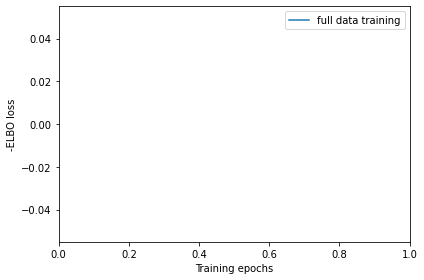

In [24]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200
) 

mod.train(max_epochs=1, #30000 -actual value, 300 dummy value
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]